In [1]:
import BMTextTokenizer as bmt
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import stanza
from itertools import permutations
%matplotlib inline

In [2]:
# Default stanza pipeline to be used throughout this notebook
pretokenized_nlp = stanza.Pipeline(lang='en', package='craft', processor='tokenize', tokenize_pretokenized=True) 

2022-01-21 14:06:50 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | craft   |
| pos       | craft   |
| lemma     | craft   |
| depparse  | craft   |

2022-01-21 14:06:50 INFO: Use device: cpu
2022-01-21 14:06:50 INFO: Loading: tokenize
2022-01-21 14:06:50 INFO: Loading: pos
2022-01-21 14:06:50 INFO: Loading: lemma
2022-01-21 14:06:50 INFO: Loading: depparse
2022-01-21 14:06:51 INFO: Done loading processors!


In [3]:
path = '/Volumes/GoogleDrive/My Drive/_My Data Analytics Exercise/Exercise/Biopython/CE/'

In [4]:
df = pd.read_csv(path+'all_interactions.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   interactionId  1124 non-null   object
 1   sentence       1124 non-null   object
 2   entities       1124 non-null   object
 3   interaction    1124 non-null   object
 4   relationship   1124 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 44.0+ KB


In [6]:
have_interactions = df[df['relationship']==1]

In [7]:
have_interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 1 to 1122
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   interactionId  825 non-null    object
 1   sentence       825 non-null    object
 2   entities       825 non-null    object
 3   interaction    825 non-null    object
 4   relationship   825 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 38.7+ KB


In [8]:
have_interactions.head()

,interactionId,sentence,entities,interaction,relationship
1,BioInfer_d682,The recombinant material is similar to authent...,"[('T1', 'Individual_protein', 'skeletal actin'...","{'R1': ('T1', 'T3')}",1
3,BioInfer_d595,The common denominator is impaired beta-cateni...,"[('T1', 'Individual_protein', 'beta-catenin', ...","{'R1': ('T1', 'T2'), 'R2': ('T1', 'T3')}",1
8,BioInfer_d538,"Significantly, those actin mutants exhibiting ...","[('T4', 'Gene/protein/RNA', 'actin', (21, 26))...","{'R1': ('T1', 'T2'), 'R2': ('T1', 'T3')}",1
11,BioInfer_d54,Analyses of dynamic light scattering data by s...,"[('T6', 'Individual_protein', 'actin', (129, 1...","{'R1': ('T1', 'T3'), 'R2': ('T2', 'T4'), 'R3':...",1
12,BioInfer_d777,Treatment with HNE resulted in activation of e...,"[('T6', 'Protein_family_or_group', 'extracellu...","{'R1': ('T1', 'T6'), 'R2': ('T2', 'T6')}",1


### Analysis of the POS distribution of connected Tokens

In [9]:
sample = have_interactions.loc[11, 'sentence']
sample

'Analyses of dynamic light scattering data by stretched exponential fit show that vinculin has a negligible influence on internal actin filament dynamics and actin bending stiffness which contrasts with our previous observations with talin, another actin and vinculin-binding protein from focal adhesions.'

To a human reader, the understanding would be 'vinculin' has negligible influence on 'actin' related behavior, which is different from what happens between 'talin' and 'vinculin'.

The reason is that the phrase <b>'negligible influence'</b> appears between 'vinculin' and 'actin' that indicates there is <b>NO</b> interaction between two while the previous observations between 'vinculin' and 'talin' <b>'contrasts'</b> this claim.

In following analysis, I will try to look for any pattern that will support the above human reasoning and I can capture it with simple labeling functions.

In [10]:
doc = bmt.tokenizer(pretokenized_nlp, sample)

In [11]:
print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(25, " ") if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')



id: 1	word: Analyses                 	upos: NOUN  	head: show                     	deprel: nsubj
id: 2	word: of                       	upos: ADP   	head: dynamic light scattering data	deprel: case
id: 3	word: dynamic light scattering data	upos: NOUN  	head: Analyses                 	deprel: nmod
id: 4	word: by                       	upos: ADP   	head: stretched exponential fit	deprel: case
id: 5	word: stretched exponential fit	upos: NOUN  	head: Analyses                 	deprel: nmod
id: 6	word: show                     	upos: VERB  	head: root	deprel: root
id: 7	word: that                     	upos: SCONJ 	head: has                      	deprel: mark
id: 8	word: vinculin                 	upos: NOUN  	head: has                      	deprel: nsubj
id: 9	word: has                      	upos: VERB  	head: show                     	deprel: ccomp
id: 10	word: a                        	upos: DET   	head: negligible influence     	deprel: det
id: 11	word: negligible influence     	upos: NOUN 

In [12]:
%time
H = nx.Graph() # using undirected graph to establish a baseline behavior
for sent in doc.sentences:
    for word in sent.words:
        head = word.text
        tail = sent.words[word.head-1].text
        if word.upos == 'PUNCT' or sent.words[word.head-1].upos=='PUNCT':
            pass
        else:
            
            H.add_node(head, pos=word.upos, deprel=word.deprel)
            H.add_node(tail, pos=sent.words[word.head-1].upos, deprel=sent.words[word.head-1].deprel)
            H.add_edge(head, tail, weight=1)

CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 4.29 µs


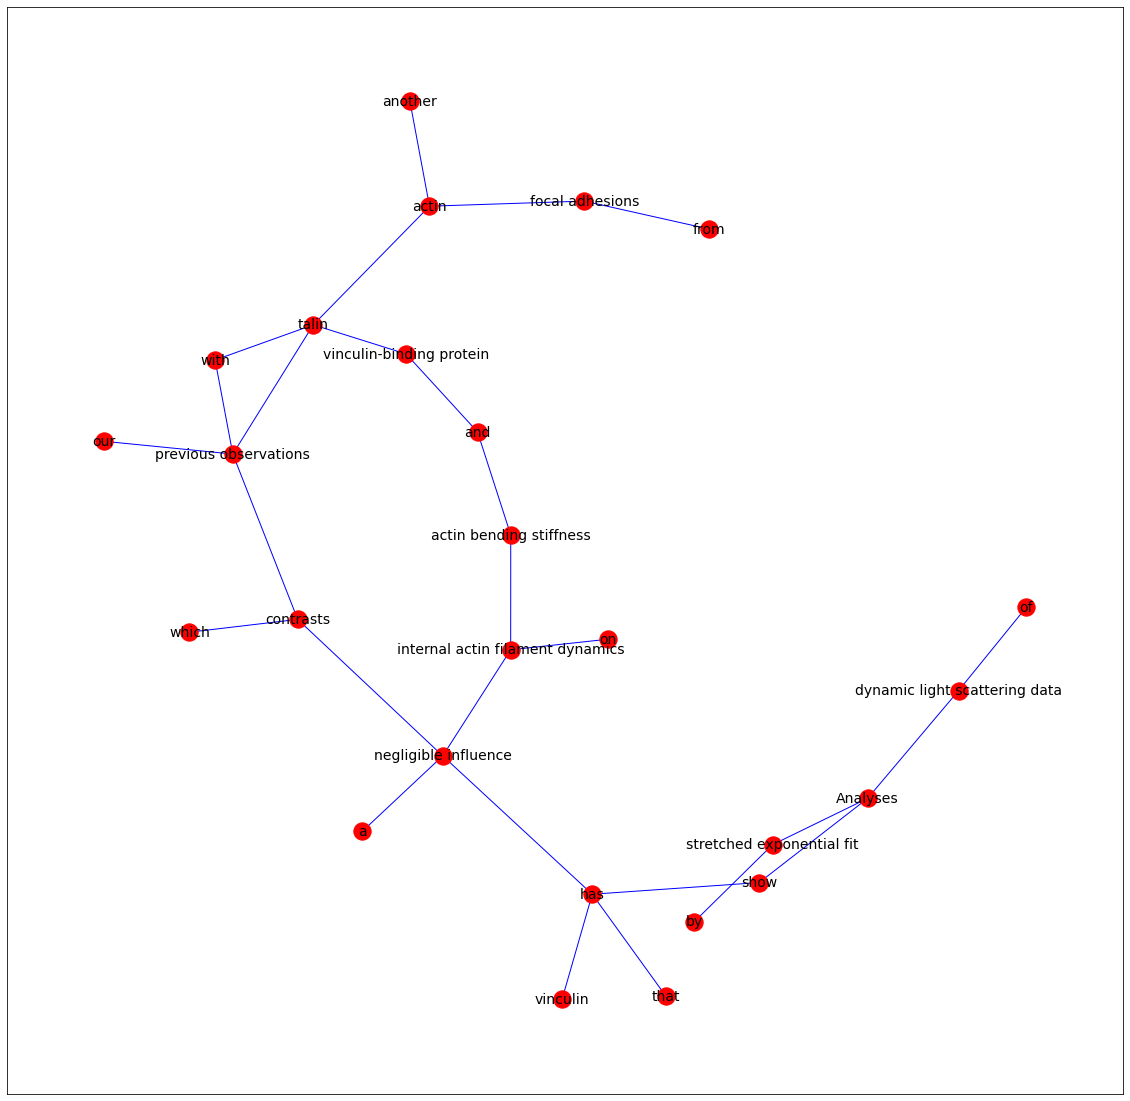

In [13]:
bmt.plot_network(H)

In [14]:
# Let's examine if 'actin', 'talin', and 'vinculin' exist as distinct nodes
entities = ['actin','talin','vinculin']
nodes = H.nodes()
atoms = []
for node in nodes:
    for entity in entities:
        if entity in node:
            atoms.append(node)
atoms

['vinculin',
 'internal actin filament dynamics',
 'actin bending stiffness',
 'talin',
 'actin',
 'vinculin-binding protein']

In [15]:
%time
tuples = permutations(atoms, 2)
simple_path = []
for t in tuples:
    #print (t)
    paths = list(nx.all_simple_paths(H, source=t[0], target=t[1]))
    for p in paths:
        #print (p)
        simple_path.append(p)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.8 µs


In [37]:
tuples = permutations(atoms, 2)
for index, t in enumerate(tuples):
    print (index, '-', t)

0 - ('vinculin', 'internal actin filament dynamics')
1 - ('vinculin', 'actin bending stiffness')
2 - ('vinculin', 'talin')
3 - ('vinculin', 'actin')
4 - ('vinculin', 'vinculin-binding protein')
5 - ('internal actin filament dynamics', 'vinculin')
6 - ('internal actin filament dynamics', 'actin bending stiffness')
7 - ('internal actin filament dynamics', 'talin')
8 - ('internal actin filament dynamics', 'actin')
9 - ('internal actin filament dynamics', 'vinculin-binding protein')
10 - ('actin bending stiffness', 'vinculin')
11 - ('actin bending stiffness', 'internal actin filament dynamics')
12 - ('actin bending stiffness', 'talin')
13 - ('actin bending stiffness', 'actin')
14 - ('actin bending stiffness', 'vinculin-binding protein')
15 - ('talin', 'vinculin')
16 - ('talin', 'internal actin filament dynamics')
17 - ('talin', 'actin bending stiffness')
18 - ('talin', 'actin')
19 - ('talin', 'vinculin-binding protein')
20 - ('actin', 'vinculin')
21 - ('actin', 'internal actin filament dyn

In [17]:
for index, p in enumerate(simple_path):
    print (index, ':', p)

0 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics']
1 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'with', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics']
2 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics']
3 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics', 'actin bending stiffness']
4 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'with', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness']
5 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness']
6 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics', 'acti

In [18]:
pos = nx.get_node_attributes(H, 'pos')

In [19]:
pos

{'Analyses': 'NOUN',
 'show': 'VERB',
 'of': 'ADP',
 'dynamic light scattering data': 'NOUN',
 'by': 'ADP',
 'stretched exponential fit': 'NOUN',
 'that': 'SCONJ',
 'has': 'VERB',
 'vinculin': 'NOUN',
 'a': 'DET',
 'negligible influence': 'NOUN',
 'on': 'ADP',
 'internal actin filament dynamics': 'NOUN',
 'and': 'CONJ',
 'actin bending stiffness': 'NOUN',
 'which': 'PRON',
 'contrasts': 'VERB',
 'with': 'ADP',
 'previous observations': 'NOUN',
 'our': 'PRON',
 'talin': 'NOUN',
 'another': 'DET',
 'actin': 'NOUN',
 'vinculin-binding protein': 'NOUN',
 'from': 'ADP',
 'focal adhesions': 'NOUN'}

In [20]:
%%time
# Regenerate those paths by replacing the token with its corresponding POS tag
POS_path = []
for p in simple_path:
    path = []
    for entry in p:
        path.append(pos[entry])
    POS_path.append(path)

CPU times: user 750 µs, sys: 230 µs, total: 980 µs
Wall time: 1.09 ms


In [21]:
pos_tags = []
for index, p in enumerate(POS_path):
    print (index, ':', p)
    for tag in p:
        if tag not in pos_tags:
            pos_tags.append(tag)

0 : ['NOUN', 'VERB', 'NOUN', 'NOUN']
1 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN']
2 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN']
3 : ['NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN']
4 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'CONJ', 'NOUN']
5 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN']
6 : ['NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN']
7 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN']
8 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'NOUN']
9 : ['NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'NOUN']
10 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NOUN']
11 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN']
12 : ['NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN']
13 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NOUN']
14 : ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN

In [22]:
pos_tags

['NOUN', 'VERB', 'ADP', 'CONJ']

In [23]:
merged = zip(simple_path, POS_path)

In [24]:
count = 0
for m in merged:
    count +=1
    print (m)
print (count)

(['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics'], ['NOUN', 'VERB', 'NOUN', 'NOUN'])
(['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'with', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics'], ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN'])
(['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics'], ['NOUN', 'VERB', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN'])
(['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics', 'actin bending stiffness'], ['NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN'])
(['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'with', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness'], ['NOUN', 

In [25]:
%%time
# Let's sort out those sentences with 'negligible influence' and 'contrast' and those without
merged = zip(simple_path, POS_path)
with_keyword = []
without_keyword = []
for m in merged:
    #print (m)
    if 'negligible influence' in m[0] or 'contrasts' in m[0]:
        with_keyword.append(m)
    else:
        without_keyword.append(m)

CPU times: user 156 µs, sys: 4 µs, total: 160 µs
Wall time: 122 µs


In [26]:
len(with_keyword), len(without_keyword)

(66, 20)

In [27]:
%%time
tag_count = {}
for tag in pos_tags:
    tag_count[tag] = 0

for entry in with_keyword:
    for item in entry[1]:
        tag_count[item] +=1/len(entry[1]) # normalise for length of the path

for tag in pos_tags:
    tag_count[tag] = round(tag_count[tag]/len(with_keyword),4) # normalize for the number of paths
    

CPU times: user 346 µs, sys: 6 µs, total: 352 µs
Wall time: 368 µs


In [28]:
tag_count

{'NOUN': 0.7257, 'VERB': 0.1769, 'ADP': 0.0531, 'CONJ': 0.0444}

In [29]:
%%time
tag_count = {}
for tag in pos_tags:
    tag_count[tag] = 0

for entry in without_keyword:
    for item in entry[1]:
        tag_count[item] +=1/len(entry[1])

for tag in pos_tags:
    tag_count[tag] = round(tag_count[tag]/len(without_keyword),4)

CPU times: user 114 µs, sys: 14 µs, total: 128 µs
Wall time: 320 µs


In [30]:
tag_count

{'NOUN': 0.86, 'VERB': 0.0, 'ADP': 0.0, 'CONJ': 0.14}

#### Observation 1:
For single sentence, paths that have meaningful causal relationship (i.e. keywords) shows a different distribution in terms of common POS tags like 'NOUN' and 'VERB'.  This may form one of many rules to classify if a sentence contains causal explanation between two entities of interest.

Follow-up is to do a sampling with more sentences with causal relationship to see if this heuristic will stand.

### Analysis of Shortest Path of the Graph

In article <b><i>"All-paths graph kernel for protein-protein interaction extraction with evaluation of cross-corpus learning"</i></b> (from Natural Language Processing in Biomedicine (BioNLP) ACL Workshop 2008 Columbus, OH, USA. 19 June 2008, BMC Bioinformatics 2008, 9(Suppl 11):S2 doi:10.1186/1471-2105-9-S11-S2, published: 19 November 2008), authors suggested that [...] words between the candidate entities or connecting them in a syntactic representation are particularly likely to carry information regarding their relationship; Bunescu and Mooney formalize this intuition for dependency graphs as the <b>shortest path hypothesis</b>.[...]

Following this hypothesis, I also analyse the shortest path connecting those entities of interest and see if there is any pattern that I can uncover and code into Labelling Function.

In [38]:
# Find shortest path(s) connecting specified nodes
tsp = nx.approximation.traveling_salesman_problem
tuples = permutations(atoms, 2)
for index, t in enumerate(tuples):
    path = tsp(H, nodes=t, cycle=False)
    print (index, ':', path) # looks useful

0 : ['internal actin filament dynamics', 'negligible influence', 'has', 'vinculin']
1 : ['actin bending stiffness', 'internal actin filament dynamics', 'negligible influence', 'has', 'vinculin']
2 : ['talin', 'previous observations', 'contrasts', 'negligible influence', 'has', 'vinculin']
3 : ['actin', 'talin', 'previous observations', 'contrasts', 'negligible influence', 'has', 'vinculin']
4 : ['vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics', 'negligible influence', 'has', 'vinculin']
5 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics']
6 : ['actin bending stiffness', 'internal actin filament dynamics']
7 : ['talin', 'previous observations', 'contrasts', 'negligible influence', 'internal actin filament dynamics']
8 : ['actin', 'talin', 'previous observations', 'contrasts', 'negligible influence', 'internal actin filament dynamics']
9 : ['vinculin-binding protein', 'and', 'actin bending stiffness', 'interna

In [39]:
%%time
# Extract those shortest paths with VERB in it
path_with_vb = []
token_tag = nx.get_node_attributes(H, 'pos')
tuples = permutations(atoms, 2)
for index, t in enumerate(tuples):
    path = tsp(H, nodes=t, cycle=False)
    for atom in path:
        if token_tag[atom]=='VERB':
            path_with_vb.append(path)

CPU times: user 40.8 ms, sys: 2.38 ms, total: 43.2 ms
Wall time: 43.8 ms


In [41]:
for index, entry in enumerate(path_with_vb):
    print (index, ':', entry)

0 : ['internal actin filament dynamics', 'negligible influence', 'has', 'vinculin']
1 : ['actin bending stiffness', 'internal actin filament dynamics', 'negligible influence', 'has', 'vinculin']
2 : ['talin', 'previous observations', 'contrasts', 'negligible influence', 'has', 'vinculin']
3 : ['talin', 'previous observations', 'contrasts', 'negligible influence', 'has', 'vinculin']
4 : ['actin', 'talin', 'previous observations', 'contrasts', 'negligible influence', 'has', 'vinculin']
5 : ['actin', 'talin', 'previous observations', 'contrasts', 'negligible influence', 'has', 'vinculin']
6 : ['vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics', 'negligible influence', 'has', 'vinculin']
7 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics']
8 : ['talin', 'previous observations', 'contrasts', 'negligible influence', 'internal actin filament dynamics']
9 : ['actin', 'talin', 'previous observations', 'contrasts', 'neg

#### Obervations 2:

From above extractions, it's obvious that token(s) between two entities of interest do convey the polarity of the relationship between then. 

Question is how to correctly label the polarity of each in-between token and summarize the relationship.